In [1]:
# Requesting and receiving data from Arduino v1

"""
Code based on code from:
https://be189.github.io/lessons/10/control_of_arduino_with_python.html
https://be189.github.io/lessons/11/control_with_buttons.html
"""

"""
Changelog:
v3
- 
v2
- added collection of hot plate IO data
- switched from Bokeh to matplotlib
v1
- small QoL changes
"""

# NOTE:
# This will not work if the Serial Monitor or Serial Plotter of the Arduino IDE open
# They keep the port busy so Python cannot communicate with Arduino

# -------------
# Imports
# -------------
import re
import asyncio
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import serial
import serial.tools.list_ports

from datetime import datetime
import os

# ---------------------------------
# Defining consts and magic numbers
# ---------------------------------
# The following should match the consts of the same name in the Arduino code
# Handshake consts
HANDSHAKE = 0
TEMP_REQUEST = 1
ON_REQUEST = 2
STREAM = 3
READ_DAQ_DELAY = 4
READ_HEAT_PARAMS = 5
# Rate at which information is transferred in a communication channel
BAUDRATE = 9600
# Delay before data recording starts, to give MAX6675 chips time to stabilize
DELAY = 0 # 250

In [2]:
# -------------
# Preliminaries
# -------------
# Switch to dark mode if using dark mode IDE
plt.style.use('dark_background')
# Folder to save output
folder = 'output\\'
if not os.path.exists(folder):
   os.makedirs(folder)

# ---------
# Functions
# ---------
def timestamp():
    return datetime.now().strftime("%Y%m%d%H%M%S")

# Should I add a function to create a new director

"""
Many of these functions are heavily borrowed from BE/EE/MedE 189
https://be189.github.io/index.html
"""

def find_arduino(port=None):
    """
    Either returns the port input to it as a parameter, or searchs for a port
    Note that on Windows devices (and potentially others as well),
    the manufacturer could not appear as 'Arduino',
    which messes up the functions ability to find the port
    For Windows, the port should be input at something like 'COM3'
    
    You can see/select the port in the Arduino IDE under
    Tools > Port: ...
    """
    # Check if a port has been input
    if port is None:
        ports = serial.tools.list_ports.comports()
        for p in ports:
            # Use manufacturer to check which port is the Ardunio port
            if p.manufacturer is not None and "Arduino" in p.manufacturer:
                port = p.device
        if port is None:
            raise Exception("Port not found. Double check that the Arduino is plugged in before further troublshooting.")
    return port

def handshake_arduino(arduino, sleep_time=DELAY, print_handshake_message=False, handshake_code=HANDSHAKE):
    """
    Performs handshake with Ardunio
    """
    # Check connection is established by sending and reciving bytes
    print("Checking if connection is established by sending and reciving bytes")
    arduino.close()
    arduino.open()
    
    # Wait for MAX6675 chips to stabilize
    print("Waiting for MAX6675 chips to stabilize")
    time.sleep(sleep_time)
    print("Stabilization complete")

    # Set a long timeout to complete handshake
    timeout = arduino.timeout
    arduino.timeout = 2

    # Read and discard everything that may be in the input buffer
    _ = arduino.read_all()

    # Send request to Arduino
    print("Sending request to Arduino")
    arduino.write(bytes([handshake_code]))

    # Read in what Arduino sent
    print("Reading in what Arduino sent")
    handshake_message = arduino.read_until()

    # Send and receive request again
    print("Sending and receiving request again")
    arduino.write(bytes([handshake_code]))
    handshake_message = arduino.read_until()

    # Print the handshake message, if desired
    if print_handshake_message:
        print("Handshake message: " + handshake_message.decode())

    # Reset the timeout
    arduino.timeout = timeout
    
def parse_raw(raw):
    """
    Parse data from Arduino separated by ","
    """
    # print(raw)
    raw = raw.decode()
    if raw[-1] != "\n":
        raise ValueError(
            "Input must end with newline, otherwise message is incomplete."
        )
    t, T1, T2, IO = raw.rstrip().split(",")
    return int(t), float(T1), float(T2), float(IO)

def set_heating_rate(heating_rate, max_temp):
    """
    Send desired heating rate (C/s) and maximum temperature (C) to Arduino
    """
    # Combine heating rate and max temp into parseable string
    rate_max = str(heating_rate) + "," + str(max_temp)

    # Send this to the Arduino
    arduino.write(bytes([READ_HEAT_PARAMS]) + (rate_max + "x").encode())

def daq_stream(arduino, duration=60, daqDelay=20, printFreq=10):
    """
    Obtain `n_data` data points from an Arduino stream
    with a delay of `delay` milliseconds between each
    duration and printFreq is in SEC
    daqDelay is in MILLISEC
    """
    # Get time
    start_time = time.time()
    end_time = start_time + duration
    # Keep track of how frequently to print time elapsed
    time_of_last_print = start_time
    
    # Specify delay
    arduino.write(bytes([READ_DAQ_DELAY]) + (str(daqDelay) + "x").encode())

    # Initialize output
    time_ms = []
    temp1 = []
    temp2 = []
    onOff = []

    # Turn on the stream
    arduino.write(bytes([STREAM]))
    
    print("Time elapsed (sec):")
    print("0 / " + str(duration))
    # Receive data
    while time.time() < end_time :
        
        if time.time() > time_of_last_print + printFreq:
            print(str(round(time.time() - start_time)) + " / " + str(duration))
            time_of_last_print = time.time()
            
        raw = arduino.read_until()
        try:
            t, T1, T2, IO = parse_raw(raw)
            time_ms.append(t)
            temp1.append(T1)
            temp2.append(T2)
            onOff.append(IO)
        except:
            print("Error: parse_raw failed " + str(raw))
            pass
    print(str(duration) + " / " + str(duration))
    
    # Turn off the stream
    arduino.write(bytes([ON_REQUEST]))

    return pd.DataFrame({'time (ms)': time_ms, 'temp1 (C)': temp1, 'temp2 (C)': temp2, 'on/off': onOff})

In [26]:
# ---------------------------
# Calling handshake functions
# ---------------------------
# Get port
print("Finding port")
port = find_arduino()
# Open port
print("Opening port")
arduino = serial.Serial(port, baudrate=9600, timeout=1)
print("Establishing handshake")
# Make handshake
handshake_arduino(arduino, print_handshake_message=True)

# ----------------------------------------
# Setting heating rate and collecting data
# ----------------------------------------
# Heating rate (C/s)
heating_rate = 0.5
# Max temp (C)
max_temp = 300
# Sending this info to the Arduino
print("Setting heating rate")
set_heating_rate(heating_rate, max_temp)
print(arduino.read_until())

# Collecting data
print("Starting PWM\n")
df = daq_stream(arduino, duration=1)
print("Done!")
df['time (sec)'] = df['time (ms)'] / 1000
# df.to_pickle(folder + "./data_PWM_" + timestamp() + ".pkl")
df.to_pickle(folder + "./data_PWM_500_500_" + timestamp() + ".pkl")

# Closing connection with Arduino
arduino.close()

Finding port
Opening port
Establishing handshake
Checking if connection is established by sending and reciving bytes
Waiting for MAX6675 chips to stabilize
Stabilization complete
Sending request to Arduino
Reading in what Arduino sent
Sending and receiving request again
Handshake message: Message received.

Setting heating rate
b'0.5,300\r\n'
Starting PWM

Time elapsed (sec):
0 / 1
1 / 1
Done!


In [27]:
print(df)
# arduino.close()

    time (ms)  temp1 (C)  temp2 (C)  on/off  time (sec)
0        1059     148.75     161.25     0.0       1.059
1        1080     148.75     161.25     1.0       1.080
2        1101     148.75     161.25     1.0       1.101
3        1122     148.75     161.25     1.0       1.122
4        1153     148.75     161.25     1.0       1.153
5        1191     148.75     161.25     1.0       1.191
6        1231     148.75     161.25     1.0       1.231
7        1270     148.75     161.25     1.0       1.270
8        1310     148.75     161.25     1.0       1.310
9        1350     148.75     161.25     1.0       1.350
10       1389     148.75     161.25     1.0       1.389
11       1429     148.75     161.25     1.0       1.429
12       1468     148.75     161.25     1.0       1.468
13       1508     148.75     161.25     1.0       1.508
14       1548     148.75     161.25     1.0       1.548
15       1587     148.75     161.25     1.0       1.587
16       1627     148.75     161.25     0.0     

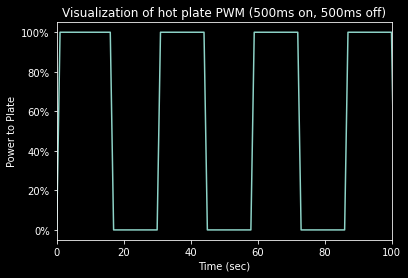

In [146]:
f = plt.figure()
plt.plot(df['on/off'])
plt.xlabel("Time (sec)")
plt.ylabel("Power to Plate")
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
# plt.title("Visualization of hot plate PWM (" + str(heating_rate) + " C/s)");
# f.savefig(folder + "\plate_PWM_" + timestamp() + ".pdf", bbox_inches='tight')
plt.xlim(0, 100)
plt.title("Visualization of hot plate PWM (500ms on, 500ms off)");
f.savefig(folder + "\plate_PWM_500_500_" + timestamp() + ".pdf", bbox_inches='tight')

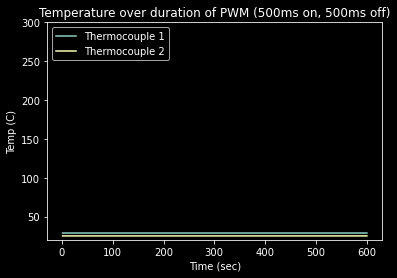

In [147]:
# Always save plots as PDFs!
f = plt.figure()
plt.plot(df['time (sec)'], df['temp1 (C)'], label='Thermocouple 1')
plt.plot(df['time (sec)'], df['temp2 (C)'], label='Thermocouple 2')
plt.ylim([20, 300])
plt.xlabel("Time (sec)")
plt.ylabel("Temp (C)")
plt.legend(loc=2)
# plt.title("Temperature over duration of PWM");
# f.savefig(folder + "temp_PWM_" + timestamp() + ".pdf", bbox_inches='tight')
plt.title("Temperature over duration of PWM (500ms on, 500ms off)");
f.savefig(folder + "temp_PWM_500_500_" + timestamp() + ".pdf", bbox_inches='tight')